In [1]:
import datetime
from datetime import timedelta
import calendar ## to print names
import pytz ## for timezones
utc=pytz.UTC
from GitLabHandler import * 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle, Circle
#PathPatch
#from matplotlib.path import Path
#import math


#Standard (4:3) - 25.4 x 19.05 cm.  10 x 7.5 inches 
#Widescreen (16:9) - 33.867 x 19.05 cm. 13.33 x 7.5 inches 


### Configuration

In [11]:
outname = 'summary.pdf'
colorsbyrepo=False ## If set to TRue, need to have repo to the issue
start = datetime(2023, 7, 1) 
end = datetime(2023, 8, 31 ) 
nslots=4 ## number of possible overlapping lines

### Code

In [3]:
'''If I want to run on multiple repository. I need to be able to track things and to merge them'''
def add_repo_to_issues(gitlab):
    for i in gitlab.issues:
        i.repo = gitlab.repo.replace('%2F','/')
    return gitlab
def merge_gitlabs_issues(gitlab1,gitlab2):
    gitlab1.issues.extend(gitlab2.issues)
    return gitlab1

In [4]:
## collect informations
gitlab = GitLabHandler("amarini/test")
gitlab.read_token_fromfile(os.environ["HOME"]+ "/.ssh/gitlab_token")
gitlab.GetIssues()
gitlab.GetLabelEvents()

#gitlab2=GitLabHandler("cms-hcg/comb/summer21")
#gitlab2.read_token_fromfile(os.environ["HOME"]+ "/.ssh/gitlab_token")
#gitlab2.GetIssues()
#gitlab2.GetLabelEvents()

#gitlab = GitLabHandler("")
#gitlab = merge_gitlabs_issues(gitlab,add_repo_to_issues(gitlab1))
#gitlab = merge_gitlabs_issues(gitlab,add_repo_to_issues(gitlab2))

Dump all the labels in the repository for info

In [6]:
## Available labels:
labels=[]
for myIssue in gitlab.issues:
    for le in myIssue.label_events:
        labels.append(le.label)
labels=list(set(labels))
print("labels are:",','.join(labels))

labels are: new,old,another label


In [12]:
margin = 0.01
offset =0.1
dw = 0.125
dh = 0.15
y0=1.-0.245

repos = list(set([ i.repo for i in gitlab.issues ])) if colorsbyrepo else []
plot_labels=["another label","new","Contacts"] # Issue title is "New issue"]
colors = ['lightskyblue', 'lightcoral','yellowgreen', 'gold','darkorange', 'darkred','darkgreen','blueviolet','tab:pink','gray','royalblue','tab:green']

slots=[ (None,None,None,None,None) for _ in range(0,nslots)] ## (Issue title, label, start_x, end_x, repo)  if issue is in the slot

def get_x(weekday):
    '''Get x position to draw the day-boxse'''
    return weekday*dw+ margin + offset

def draw_text(current):
    '''Draw Month, year and days names. (not days numbers)'''
    plt.text(0.02, .999, calendar.month_name[current.month] + " %d"%(current.year), ha='left', va='top', fontsize=24)
    for i in range(0,7):
        plt.text(get_x(i)+ margin, .93, calendar.day_abbr[i], ha='left',va='top',fontsize='16',color='gray')
    ## Draw something like month name, days name, ...
    
def issue_open_today(title,label, today,issues= gitlab.issues)->bool:
    '''Determine if issue title was open on that day. With that label assigned'''
    eod = utc.localize(today + timedelta(days=1)+ timedelta(seconds=-1))
    last_action_before_eod= False ## True = add, False = remove
    for myIssue in issues:
        if myIssue.title != title : continue ##
        #if len(set(labels) & set([ le.label for le in myIssue.label_events ]) ) ==0: continue ## the issue never had label
        
        for le in myIssue.label_events:
            #if le.label not in plot_labels: continue ## only consider the current label
            if le.label != label : continue
            if le.action=='add':
                if le.date < eod: last_action_before_eod= True
            if le.action=='remove':
                if le.date < eod: last_action_before_eod= False
    return last_action_before_eod        
    
def milestone_duedate(today, labels=plot_labels,issues=gitlab.issues):
    '''Determine if today is a milestone, and retrieve informations.
    Issues considered are the ones that at a certain point had label.
    '''
    milestones=[]
    eod = today + timedelta(days=1) - timedelta(seconds=1)
    for myIssue in issues:
        #if myIssue.title not in labels: continue ## titles not labels
        if len(set(labels) & set([ le.label for le in myIssue.label_events ]) ) ==0: continue
        if myIssue.milestone and myIssue.milestone.due_date > (today - timedelta(seconds=1)) and myIssue.milestone.due_date<eod:
            milestones.append(myIssue.milestone.title)
    return milestones

def clean_slots(slots,current, y0, colors=colors,labels=plot_labels,colorsbyrepo=colorsbyrepo):
    ## plot_labels -> list of labels to color
    rects=[]
    to_clean=[]
    for islot,(title, label,x1,x2,repo) in enumerate(slots):
        y= y0 + dh/(len(slots) +2. )*islot + margin*0.2
        if title == None : continue ## the slot is empy
        if current != None and issue_open_today(title,label,current): continue ## don't clean if it is open
        to_clean.append(islot)
        rects.append(Rectangle(
            (x1,y) ,
            x2-x1,dh/(len(slots)+2.)-margin*0.2,
            facecolor = colors[ labels.index(label if not colorsbyrepo else repo) ],  ## 
            edgecolor='black', 
            lw=1, 
            ls='-'
            ))
        plt.text(x1 + margin*0.2,y+margin*0.5,title,fontsize=9,color="black")
    for islot in to_clean:
        slots[islot] = (None,None,None,None,None)
    return rects
    
## PLOT MILESTONES
## PLOT EPIC

ndays 62
saving and reset


<Figure size 640x480 with 0 Axes>

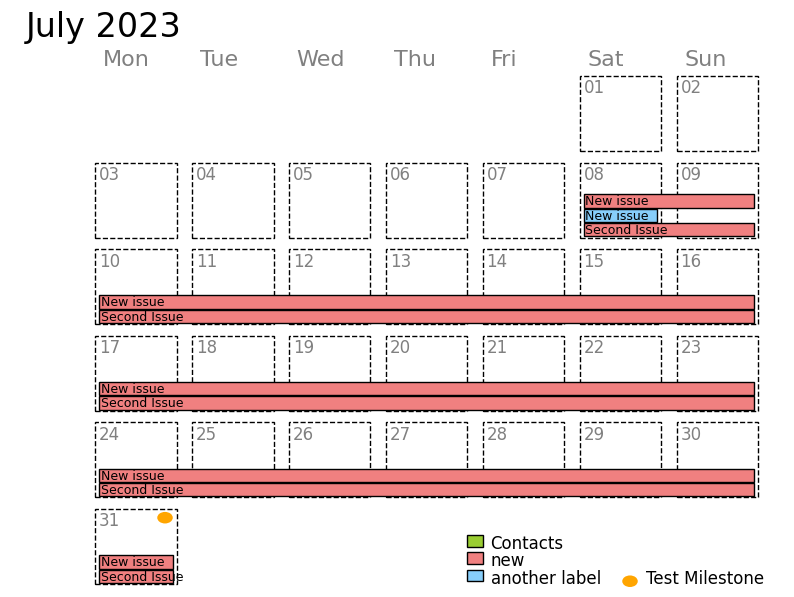

saving and reset


<Figure size 640x480 with 0 Axes>

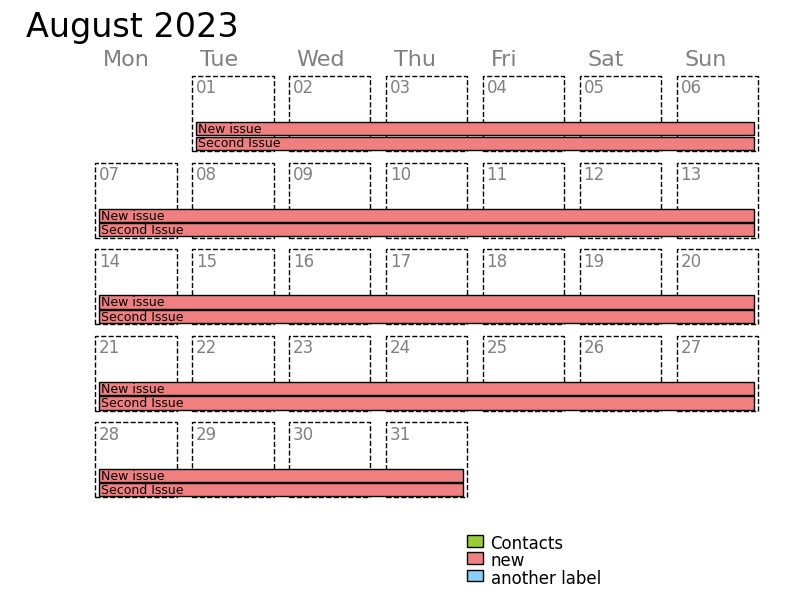

<Figure size 640x480 with 0 Axes>

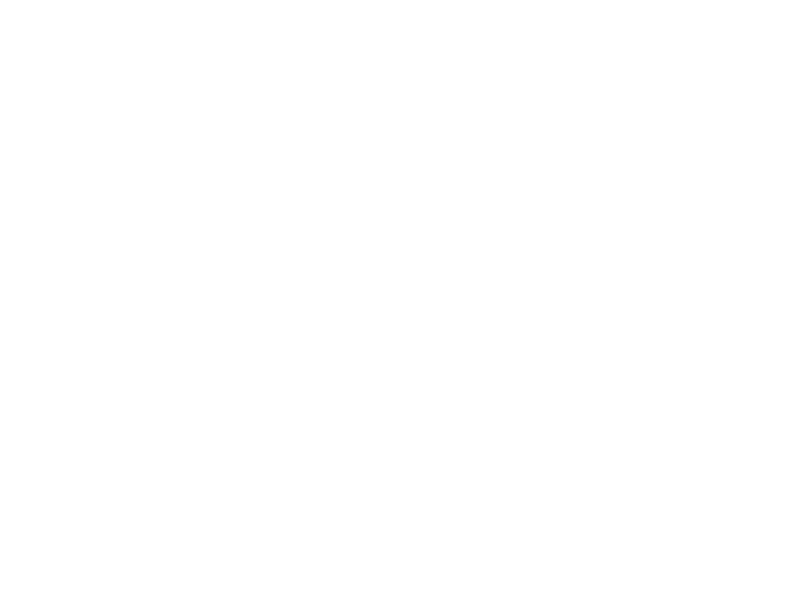

In [13]:
plt.figure().clear()
#fig = plt.figure()
fig,ax = plt.subplots(figsize=(10, 7.5))
plt.axis('off')
#fig.figsize(25.4,19.05)
#fig.set_size_inches()
pp = PdfPages(outname)

ax= fig.axes
#print ("Axes",len(ax))

ndays = (end-start).days +1
month= start.month
y= y0
rects=[] ## calendar
rects2=[]## draw after
rects3=[] 

print("ndays",ndays)
isstart=True
for iday in range(0,ndays):
    current = start + timedelta(iday)
    if current.weekday() == 0 and not isstart: ## shift one row
        y-=dh 
        #print(">shifting y",y)
    if month != current.month:
        #print ("New month",month,"->",current.month)
        pass
    month = current.month
    ## (x,y), w, h
    x = get_x(current.weekday())
    #print("iday,x,y",iday,x,y)
    isstart=False
    ## draw day box
    rects.append( Rectangle( (x,y) ,dw-margin*2,dh-2*margin,facecolor = 'white', edgecolor='black', lw=1, ls='--'))
    ## draw day number
    plt.text(x+0.5*margin, y+dh-margin*2.5, current.strftime("%d"), ha='left',va='top',fontsize=12,color="gray")
    
    ### CHECK AND DRAW MILESTONES
    if len( milestone_duedate(current) ) >0:
        #print (">> MILESTONE",milestone_duedate(current))
        ## bottom-left
        #rects3.append( Circle((x+margin*1.5, y+margin * 1.5), margin, ec="none", color='orange') ) 
        ## top-right
        rects3.append( Circle((x+dw-margin*3.5, y+dh-3.5*margin), margin, ec="none", color='orange') ) 
        #draw milestone legend
        x1,y1 = .8,0.
        rects2.append( Circle((x1,y1 + margin), margin, ec="none", color='orange')  )
        plt.text(x1 +margin*2 ,y1, 
                 ", ".join(milestone_duedate(current)) ,
                 ha='left',va='bottom',fontsize=12,color="black")
    ### TODO ADD EPIC
    ####### CHECK ISSUES
    labels = plot_labels if not colorsbyrepo else repos
    rects2.extend( clean_slots(slots,current,y,labels=labels)  )### check if some slot can be cleaned
    for myIssue in gitlab.issues:
        myRepo = myIssue.repo if hasattr(myIssue,'repo') else None
        for mylabel in plot_labels:
            if issue_open_today(myIssue.title,mylabel, current):
                # check if it is already in a slot
                isInSlot=False
                #x = get_x(current.weekday())
                for islot,(title,label,x1,x2,repo) in enumerate(slots): 
                    if title != None and title == myIssue.title:
                        ## if by label, then they are in slot if also label match
                        if label == mylabel and not colorsbyrepo:
                            isInSlot=True
                            slots[islot] = (title,mylabel,x1, x+ dw-margin*2.5 ,repo)
                        ##if by repo, they are in slot if repo match
                        if colorsbyrepo and hasattr(myIssue,'repo') and repo ==myIssue.repo:
                            isInSlot=True
                            slots[islot] = (title,mylabel,x1, x+ dw-margin*2.5 ,repo)

                if not isInSlot:
                    ## find first free slot
                    found=False
                    for islot,(title,label,x1,x2,repo) in enumerate(slots): 
                        if title == None and not found:
                            found =True
                            slots[islot] = (myIssue.title,mylabel, x+margin*0.5, x+ dw-margin*2.5,myRepo)
                    if not found:
                        raise ValueError("I didn't find a valid slot. Try increasing nslots: ",nslots, slots)

    ## dump slots if it is Sunday (or end of month or last day)
    if (current+ timedelta(days=1)).month != month or iday == ndays-1 or current.weekday()==6:
        rects2.extend( clean_slots(slots,None,y,labels=labels)  )### dump all the slots, current == Absurd
    
    ## draw issues legend
    if (current+ timedelta(days=1)).month != month or iday == ndays-1:
        x1,y1 = .8,0.
        labels = plot_labels if not colorsbyrepo else repos
        for il,label in enumerate(labels):
            y1+=0.03
            if il %4 == 0:
                x1-=0.2
                y1=0.
            rects2.append( Rectangle((x1-margin,y1 + margin), margin*2, margin*2, ec="black", color=colors[il])  )
            plt.text(x1 +margin*2 ,y1, 
                 label ,
                 ha='left',va='bottom',fontsize=12,color="black")
        
    ### ACTUALLY DRAW, CHANGE PDF AND RESET VARIABLES at the end of the month.    
    if (current+ timedelta(days=1)).month != month or iday == ndays-1: 
        print ("saving and reset")
        for r in rects: ax[0].add_artist(r) ## now draw them
        for r in rects2: ax[0].add_artist(r) ## now draw them
        for r in rects3: ax[0].add_artist(r) ## now draw them
        draw_text(current)
        plt.savefig(pp, format='pdf')
        plt.show()
        plt.figure().clear()
        fig,ax = plt.subplots(figsize=(10, 7.5))
        plt.axis('off')
        ax= fig.axes
        y=y0
        isstart=True
        rects=[] 
        rects2=[]
        rects3=[]

pp.close()
plt.show()

In [7]:
gitlab.issues[1].milestone.Print()

 --- MILESTONE: 10033 1 ----
 title: Test Milestone
 due_date: 2023-07-31 00:00:00
 --------------------------------------
